In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import tensorflow as tf
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing import image

import os
import numpy as np

In [11]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set TensorFlow to use only the first GPU (GPU:0)
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        print(e)

Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [42]:
from tensorflow.keras.saving import register_keras_serializable
import tensorflow as tf
from tensorflow.keras import layers, Model

@register_keras_serializable()
class UNet(Model):
    def __init__(self, input_size=(256, 256, 3), num_classes=1, **kwargs):
        super(UNet, self).__init__(**kwargs)  # ✅ Accepts 'name', 'trainable', etc.

        # Store attributes
        self.input_size = input_size
        self.num_classes = num_classes

        # Encoder
        self.enc_conv1 = self.conv_block(64)
        self.enc_conv2 = self.conv_block(128)
        self.enc_conv3 = self.conv_block(256)
        self.enc_conv4 = self.conv_block(512)

        # Bottleneck
        self.bottleneck = self.conv_block(1024, pool=False)

        # Decoder
        self.upconv4 = self.upconv_block(512)
        self.upconv3 = self.upconv_block(256)
        self.upconv2 = self.upconv_block(128)
        self.upconv1 = self.upconv_block(64)

        # Output Layer
        self.output_layer = layers.Conv2D(self.num_classes, (1, 1), activation='sigmoid', padding='same')

    def conv_block(self, filters, pool=True):
        """Creates a convolutional block with Batch Normalization before ReLU."""
        conv = tf.keras.Sequential([
            layers.Conv2D(filters, (3, 3), padding='same'),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters, (3, 3), padding='same'),
            layers.BatchNormalization(),
            layers.ReLU(),
        ])
        return conv if not pool else (conv, layers.MaxPooling2D(pool_size=(2, 2)))

    def upconv_block(self, filters):
        """Creates an upsampling block with Batch Normalization before ReLU."""
        return tf.keras.Sequential([
            layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same'),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters, (3, 3), padding='same'),
            layers.BatchNormalization(),
            layers.ReLU()
        ])

    def call(self, inputs):
        # Encoder
        enc1 = self.enc_conv1[0](inputs)
        pool1 = self.enc_conv1[1](enc1)

        enc2 = self.enc_conv2[0](pool1)
        pool2 = self.enc_conv2[1](enc2)

        enc3 = self.enc_conv3[0](pool2)
        pool3 = self.enc_conv3[1](enc3)

        enc4 = self.enc_conv4[0](pool3)
        pool4 = self.enc_conv4[1](enc4)

        # Bottleneck
        bottleneck = self.bottleneck(pool4)

        # Decoder
        up4 = self.upconv4(bottleneck)
        up4 = layers.Concatenate()([up4, enc4])

        up3 = self.upconv3(up4)
        up3 = layers.Concatenate()([up3, enc3])

        up2 = self.upconv2(up3)
        up2 = layers.Concatenate()([up2, enc2])

        up1 = self.upconv1(up2)
        up1 = layers.Concatenate()([up1, enc1])

        # Output layer
        output = self.output_layer(up1)

        return output

    # ✅ Fix: Ensure `get_config()` includes all parameters
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_size": self.input_size,
            "num_classes": self.num_classes
        })
        return config

    # ✅ Fix: Ensure proper deserialization
    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [43]:


# Instantiate the model

unet = UNet(input_size=(256, 256, 1), num_classes=1)

# Summary of the model architecture
unet.build((None, 256, 256, 1))  # Input shape
unet.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'u_net_6', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "u_net_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_54 (Sequential)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_55 (Sequential)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_56 (Sequential)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_57 (Sequential)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_58 (Sequential)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_59 (Sequential)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_60 (Sequential)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_61 (Sequential)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_62 (Sequential)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_104 (Conv2D)                  │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [44]:
def load_image(image_path):
    """Load an image, decode it, and resize to 256x256"""
    img = tf.io.read_file(image_path)               # Read image
    img = tf.image.decode_png(img, channels=3)       # Decode as PNG (assuming PNG images)
    img = tf.image.resize(img, (256, 256))           # Resize to target size
    img = img / 255.0                               # Normalize to range [0, 1]
    return img

def load_mask(mask_path):
    """Load a mask, decode it, and resize to 256x256"""
    mask = tf.io.read_file(mask_path)               # Read mask image
    mask = tf.image.decode_png(mask, channels=1)     # Decode as PNG (assuming masks are single-channel)
    mask = tf.image.resize(mask, (256, 256))         # Resize to target size
    mask = mask / 255.0                             # Normalize to range [0, 1]
    return mask

def load_data(image_folder, mask_folder):
    # Get image and mask file paths
    image_paths = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder)]
    mask_paths = [os.path.join(mask_folder, fname) for fname in os.listdir(mask_folder)]

    # Shuffle the paths (optional)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

    # Load images and masks
    dataset = dataset.map(lambda x, y: (load_image(x), load_mask(y)))

    # Shuffle and batch the dataset
    dataset = dataset.shuffle(buffer_size=1000)  # Shuffle with buffer_size (adjust as needed)
    dataset = dataset.batch(batch_size=16)  # Batch size for training (adjust as needed)

    return dataset


In [45]:
# Set the directory paths
image_folder = '/content/drive/MyDrive/CV project/normalized_images'
mask_folder = '/content/drive/MyDrive/CV project/normalized_masks'

# Load the dataset
train_dataset = load_data(image_folder, mask_folder)

# Check the dataset shapes (optional)
for images, masks in train_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)

# Compile the model
unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
unet.fit(train_dataset, epochs=5)  # Adjust the number of epochs as needed

Image batch shape: (16, 256, 256, 3)
Mask batch shape: (16, 256, 256, 1)
Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 60s 615ms/step - accuracy: 0.7340 - loss: 0.5537
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 71s 525ms/step - accuracy: 0.7994 - loss: 0.4785
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 41s 538ms/step - accuracy: 0.7998 - loss: 0.4806
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 36s 540ms/step - accuracy: 0.8189 - loss: 0.4526
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 35s 537ms/step - accuracy: 0.8303 - loss: 0.4254
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 41s 539ms/step - accuracy: 0.8488 - loss: 0.3826
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 35s 535ms/step - accuracy: 0.8523 - loss: 0.3846
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 36s 534ms/step - accuracy: 0.8570 - loss: 0.3619
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 40s 537ms/step - accuracy: 0.8459 - loss: 0.3795
Epoch 10/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 35s 535ms/step - accuracy: 0.8642 - loss: 0.3521


In [61]:
# Save model architecture + weights properly
unet.save("/content/drive/MyDrive/CV project/unet_model.keras")

In [67]:
# ✅ Rebuild model manually
unet_new = UNet(input_size=(256, 256, 3), num_classes=1)

# ✅ Pass a dummy input to initialize layers
dummy_input = tf.random.normal([1, 256, 256, 3])  # Batch size 1, image size 256x256, 3 channels
_ = unet_new(dummy_input)  # Call the model once to initialize it

# ✅ Load saved weights
unet_new.load_weights("/content/drive/MyDrive/CV project/unet_model.keras")

# ✅ Recompile the model (since optimizer was lost)
unet_new.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# ✅ Verify that the model architecture is now correctly built
unet_new.summary()


Model: "u_net_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_126 (Sequential)          │ (1, 256, 256, 64)           │          39,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_56 (MaxPooling2D)      │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_127 (Sequential)          │ (1, 128, 128, 128)          │         222,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_57 (MaxPooling2D)      │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_128 (Sequential)          │ (1, 64, 64, 256)            │         887,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_58 (MaxPooling2D)      │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_129 (Sequential)          │ (1, 32, 32, 512)            │       3,544,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_59 (MaxPooling2D)      │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_130 (Sequential)          │ (1, 16, 16, 1024)           │      14,166,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_131 (Sequential)          │ (1, 32, 32, 512)            │       4,461,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_132 (Sequential)          │ (1, 64, 64, 256)            │       1,640,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_133 (Sequential)          │ (1, 128, 128, 128)          │         410,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_134 (Sequential)          │ (1, 256, 256, 64)           │         103,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_224 (Conv2D)                  │ (1, 256, 256, 1)            │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,475,649 (97.18 MB)

 Trainable params: 25,463,873 (97.14 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [56]:
# Define test dataset directories
test_images_dir = "/content/drive/MyDrive/CV project/test_normalized_images"
test_masks_dir = "/content/drive/MyDrive/CV project/test_normalized_masks"

# Load test dataset using existing `load_data()` function
test_dataset = load_data(test_images_dir, test_masks_dir)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━

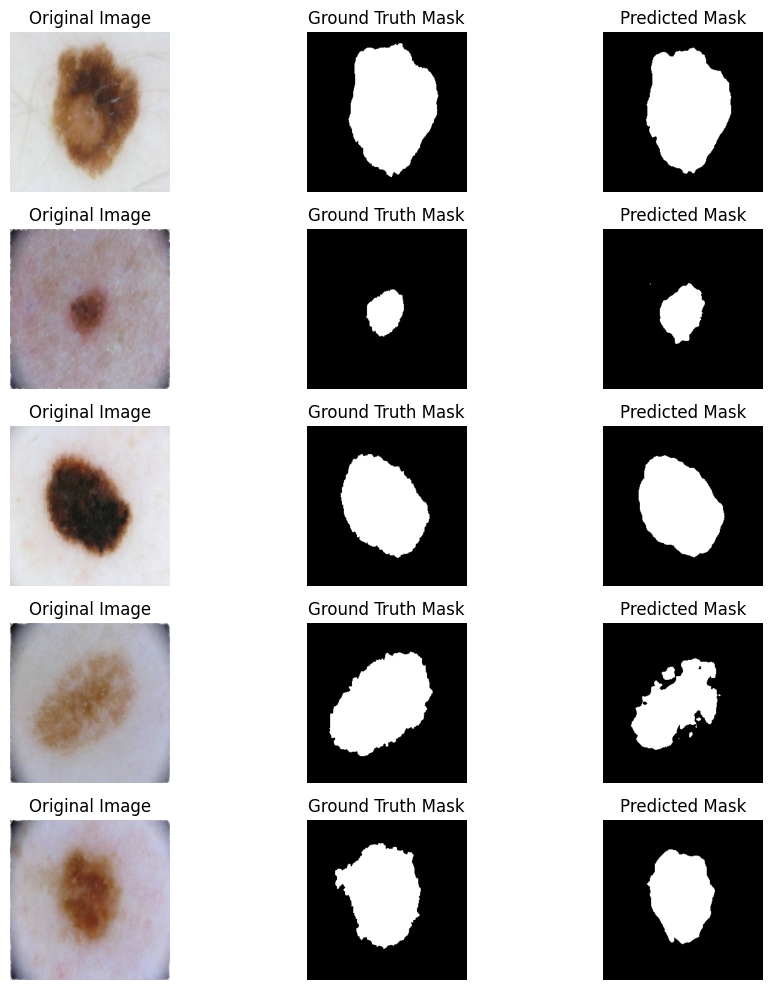

In [68]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Get sorted image filenames (only images, not masks)
image_filenames = sorted([f for f in os.listdir(test_images_dir) if f.endswith(".jpg")])

# ✅ Iterate Over Images and Select Corresponding Mask
image_list = []
y_true_list = []
y_pred_list = []

for img_filename in image_filenames:
    img_path = os.path.join(test_images_dir, img_filename)

    # ✅ Construct the corresponding mask filename
    mask_filename = img_filename.replace(".jpg", "_Segmentation.png")
    mask_path = os.path.join(test_masks_dir, mask_filename)

    # ✅ Load image and mask using your existing functions
    image_np = load_image(img_path).numpy()
    mask_tensor = load_mask(mask_path)  # Full mask path is passed correctly

    if mask_tensor is None:
        print(f"❌ Skipping: No mask found for {img_filename}")
        continue  # Skip this image if the mask is missing

    mask_np = mask_tensor.numpy()

    # ✅ Get model prediction
    predicted_mask = unet.predict(np.expand_dims(image_np, axis=0))  # Add batch dimension

    # ✅ Threshold prediction to binary mask
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

    # ✅ Store correctly paired results
    image_list.append(image_np)
    y_true_list.append(mask_np)
    y_pred_list.append(predicted_mask.squeeze())  # Remove batch dimension

# ✅ Convert Lists to Arrays
image_data = np.array(image_list)  # Shape: (N, 256, 256, 3)
y_true = np.array(y_true_list)  # Shape: (N, 256, 256, 1)
y_pred = np.array(y_pred_list)  # Shape: (N, 256, 256, 1)

# ✅ Visualize First 5 Image-Mask-Prediction Pairs
num_images_to_show = 5
fig, axes = plt.subplots(num_images_to_show, 3, figsize=(10, 10))

for i in range(num_images_to_show):
    axes[i, 0].imshow(image_data[i])
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(np.squeeze(y_true[i]), cmap="gray")
    axes[i, 1].set_title("Ground Truth Mask")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(np.squeeze(y_pred[i]), cmap="gray")
    axes[i, 2].set_title("Predicted Mask")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()
